In [1]:
import pandas as pd
import numpy as np
from catboost import Pool, CatBoostClassifier

In [2]:
N_CUSTOMERS_REDUCED = 5000
USE_REDUCED = True
cat_vars =  ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'] 

In [3]:
if USE_REDUCED:
    df = pd.read_csv('train_data_reduced.csv')
    df_lab = pd.read_csv('train_labels_reduced.csv')
    df = df.drop('Unnamed: 0', axis=1)
    df_lab = df_lab.drop('Unnamed: 0', axis=1)
else:
    df = pd.read_csv('/dev/shm/train_data.csv')
    df_lab = pd.read_csv('/dev/shm/train_labels.csv')
    
# TODO let's load this l8r
# df_test = pd.read_csv('/dev/shm/test_data.csv')

### Dataset reduction (fast prototyping!)

In [4]:
# This makes no sense if we're already operating
# on a reduced dataframe.
if not USE_REDUCED:
    unique_customers = df.customer_ID.unique()
    customer_selection = np.random.choice(unique_customers, size=N_CUSTOMERS_REDUCED, replace=False)

    df = df[df.customer_ID.isin(customer_selection)]
    df_lab = df_lab[df_lab.customer_ID.isin(customer_selection)]

    df.to_csv('train_data_reduced.csv')
    df_lab.to_csv('train_labels_reduced.csv')

## Data Exploration

In [5]:
print(f'Rows per customer: {df.shape[0] / df.customer_ID.unique().shape[0]}',)

Rows per customer: 12.044


In [6]:
df_with_labels = df.set_index('customer_ID').join(df_lab.set_index('customer_ID'))

In [7]:
len(df_with_labels)

60220

### Missing Values

In [8]:
nan_per_column = df_with_labels.isna().sum()

In [9]:
nan_percentage = nan_per_column / len(df_with_labels)
nan_percentage = nan_percentage[nan_percentage != 0]

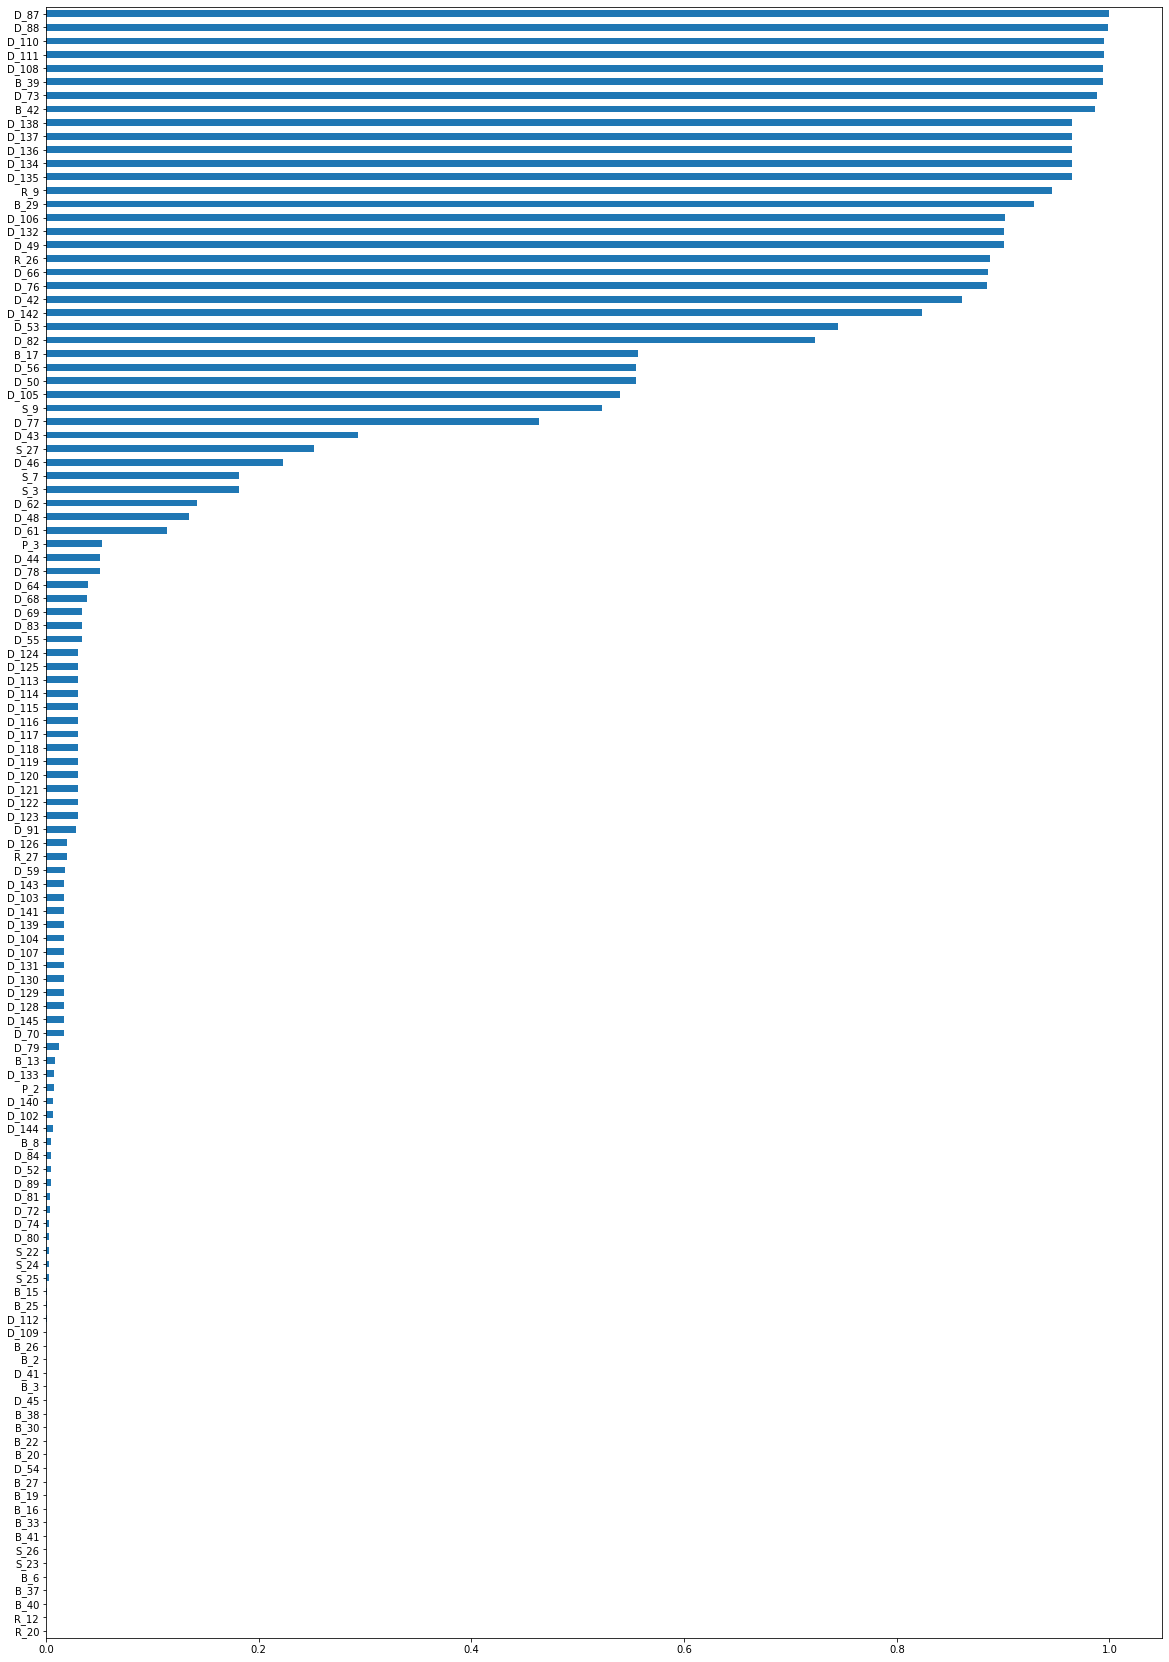

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
nan_percentage.sort_values().plot(kind='barh')
fig.set_size_inches(20, 30)

### Combine Rows into one

In [5]:
def preprocess(dataframe):
    cat_dtypes = dataframe.dtypes[cat_vars]
    dataframe[cat_vars] = dataframe[cat_vars].where(~dataframe[cat_vars].isna(), 0)

    dataframe = dataframe.astype({k: np.int32 for k in cat_dtypes[cat_dtypes == np.float64].keys()})
    #df_no_nan = df.replace(np.nan, "")
    #df_wide = dataframe.groupby('customer_ID').sum().unstack()

    df_reset = dataframe.reset_index()
    df_reset['group_index'] = dataframe.groupby('customer_ID').cumcount()
    df_reindex = df_reset.set_index(['customer_ID', 'group_index'])

    df_unstacked = df_reindex.unstack()

    df_unstacked = df_unstacked.drop('index', level=0, axis=1)
    df_unstacked = df_unstacked.drop('S_2', level=0, axis=1)

    df_unstacked.columns = [' '.join(map(str, col)).strip() for col in df_unstacked.columns.values]

    # Convert categorical features in wide dataframe to integers
    cat_vars_wide = list(filter(lambda x: any([y in x for y in cat_vars]), df_unstacked.columns))
    cat_dtypes = df_unstacked.dtypes[cat_vars_wide]

    df_unstacked = df_unstacked.astype({k: 'Int32' for k in cat_dtypes[cat_dtypes==np.float64].keys()})
    df_unstacked = df_unstacked.replace(np.nan, -1)
    cat_dtypes = df_unstacked.dtypes[cat_vars_wide]
    df_unstacked = df_unstacked.astype({k: np.int32 for k in cat_dtypes[cat_dtypes=='Int32'].keys()})
    return df_unstacked, cat_vars_wide

### Catboost

In [6]:
df_preprocessed, cat_vars_wide = preprocess(df)

In [7]:
pool = Pool(df_preprocessed, df_lab['target'], cat_vars_wide)

In [8]:
model = CatBoostClassifier(iterations=100)

In [32]:
model.fit(pool)

Learning rate set to 0.169198
0:	learn: 0.5275204	total: 167ms	remaining: 16.6s
1:	learn: 0.4298490	total: 227ms	remaining: 11.1s
2:	learn: 0.3789158	total: 283ms	remaining: 9.16s
3:	learn: 0.3452437	total: 337ms	remaining: 8.09s
4:	learn: 0.3185594	total: 392ms	remaining: 7.46s
5:	learn: 0.2984580	total: 446ms	remaining: 6.99s
6:	learn: 0.2862024	total: 507ms	remaining: 6.73s
7:	learn: 0.2776625	total: 559ms	remaining: 6.43s
8:	learn: 0.2679410	total: 612ms	remaining: 6.18s
9:	learn: 0.2603863	total: 667ms	remaining: 6s
10:	learn: 0.2533506	total: 792ms	remaining: 6.41s
11:	learn: 0.2475372	total: 845ms	remaining: 6.19s
12:	learn: 0.2417533	total: 897ms	remaining: 6s
13:	learn: 0.2373224	total: 950ms	remaining: 5.84s
14:	learn: 0.2341591	total: 1s	remaining: 5.7s
15:	learn: 0.2310212	total: 1.06s	remaining: 5.56s
16:	learn: 0.2283382	total: 1.11s	remaining: 5.43s
17:	learn: 0.2246385	total: 1.17s	remaining: 5.31s
18:	learn: 0.2211120	total: 1.22s	remaining: 5.2s
19:	learn: 0.2184288	t

# Evaluation

In [47]:
# asd

In [52]:
from catboost import cv

# parameters for training inside cv:
params = {
    'loss_function': 'Logloss',
    'iterations': 100,
    #'custom_loss': 'AUC',
    'learning_rate': 0.5,
}



def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-Logloss-mean'].min()
    best_iter = cv_data['test-Logloss-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-Logloss-std'][best_iter],
        best_iter)
    )


In [57]:
cv_data = cv(
    params = params,
    pool = pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

print_cv_summary(cv_data)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.2597021076
bestIteration = 18

Training on fold [1/5]


KeyboardInterrupt: 

In [ ]:

grid = {'depth': [4, 6, 7, 8,9,10]}
model = CatBoostClassifier(iterations=300, l2_leaf_reg=7, depth=7, learning_rate=0.1, verbose=False, task_type="GPU",)

grid_search_result = model.grid_search(grid, 
                                       X=pool, 
                                       plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.2492429657
bestIteration = 205
0:	loss: 0.2492430	best: 0.2492430 (0)	total: 18.1s	remaining: 1m 30s
bestTest = 0.2457527771
bestIteration = 239
1:	loss: 0.2457528	best: 0.2457528 (1)	total: 50.8s	remaining: 1m 41s
bestTest = 0.2500224915
bestIteration = 213
2:	loss: 0.2500225	best: 0.2457528 (1)	total: 1m 35s	remaining: 1m 35s
bestTest = 0.240551651
bestIteration = 138
3:	loss: 0.2405517	best: 0.2405517 (3)	total: 2m 40s	remaining: 1m 20s
bestTest = 0.2474620361
bestIteration = 99
4:	loss: 0.2474620	best: 0.2405517 (3)	total: 4m 25s	remaining: 53s


In [ ]:
grid_search_result['params']

<AxesSubplot:xlabel='iterations'>

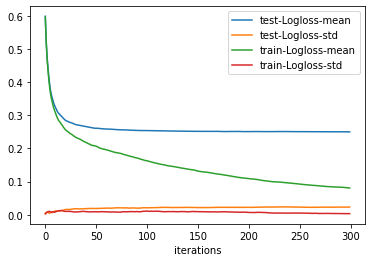

In [75]:
pd.DataFrame(grid_search_result['cv_results']).set_index('iterations').plot()

# Prediction

In [35]:
df_test = pd.read_csv('/dev/shm/test_data.csv')

In [38]:
df_test_preprocessed, cat_vars_wide = preprocess(df_test)

In [39]:
preds = model.predict_proba(df_test_preprocessed)[:,1]

In [46]:
preds

array([0.1585083 , 0.003935  , 0.04737708, ..., 0.64333704, 0.24767759,
       0.10321146])

In [41]:
df_preds = df_test_preprocessed.assign(p=preds)

In [42]:
a=df_preds['p'].reset_index()

In [43]:
a.groupby('customer_ID').mean().rename(columns={"p":"prediction"}).to_csv('preds_wideframe_prototype.csv')